list of techniques [here](https://blog.floydhub.com/ten-techniques-from-fast-ai/)

TODO
- learning rate diff each layer
- freeze layer
- data loader wrapper
- save model
- early stop

In [9]:
%reload_ext autoreload
%autoreload 2
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
import copy

%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [11]:
transform = transforms.Compose([
#                                    transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
# mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# mnist_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
# data_loader_train = DataLoader(mnist_trainset, 64, shuffle=True, num_workers=8)
# data_loader_test = DataLoader(mnist_testset, 64, shuffle=True, num_workers=8)

In [12]:
temp_raw_data_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
class TempDataSet(Dataset):
    def __getitem__(self, index):
        return temp_raw_data_set[index]
    def __len__(self):
        return 6
temp_data_set = TempDataSet()
data_loader_train = DataLoader(temp_data_set, 3, shuffle=True, num_workers=8)
data_loader_test = DataLoader(temp_data_set, 3, shuffle=True, num_workers=8)

Files already downloaded and verified


In [13]:
import RestNet
model = RestNet.ResNet18().to(device)
criterion = F.cross_entropy

In [6]:
# model = torchvision.models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

### Learning Rates [Choose one]
1. Different LR [worse] (maybe we have to use log scale)

In [7]:
lr = 0.001
num_children = len([c for c in model.children()])
param_groups = []
for i, child in enumerate(model.children()):
    denorm = num_children-i
    param_groups.append({
        'params': child.parameters(), 'lr': lr/denorm
    })
optimizer = optim.Adam(param_groups, lr=0.001, weight_decay=0.0) #weight_decay (L2 regularization) makes thing worse

In [8]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.00014285714285714287
0.00016666666666666666
0.0002
0.00025
0.0003333333333333333
0.0005
0.001


2. Static Learning Rate

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train

### Find learning rate

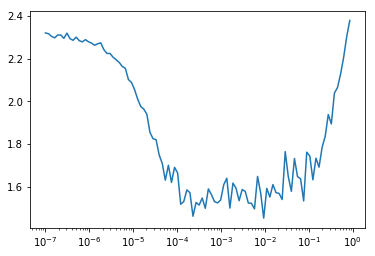

In [21]:
from exitai.learner import Learner
model = RestNet.ResNet18().to(device)
learner = Learner(data_loader_train, data_loader_test, model, criterion)
learner.lr_find(1e-7, 1)

### Train with static lr

---- epoch:0 ------
   [train] Average loss: 2.7841, acc: 34.28%
   [test] Average loss: 2.4879, acc: 43.33%
---- epoch:1 ------
   [train] Average loss: 1.8972, acc: 56.33%
   [test] Average loss: 1.8697, acc: 58.17%
---- epoch:2 ------
   [train] Average loss: 1.5077, acc: 65.97%
   [test] Average loss: 1.3887, acc: 68.50%
---- epoch:3 ------
   [train] Average loss: 1.2127, acc: 72.42%
   [test] Average loss: 1.1955, acc: 73.29%
---- epoch:4 ------
   [train] Average loss: 0.9844, acc: 77.89%
   [test] Average loss: 1.1887, acc: 74.70%
---- epoch:5 ------
   [train] Average loss: 0.8182, acc: 81.61%
   [test] Average loss: 1.0386, acc: 77.59%
---- epoch:6 ------
   [train] Average loss: 0.6807, acc: 84.71%
   [test] Average loss: 1.0607, acc: 78.15%
---- epoch:7 ------
   [train] Average loss: 0.5639, acc: 87.30%
   [test] Average loss: 1.0978, acc: 78.06%
---- epoch:8 ------
   [train] Average loss: 0.4526, acc: 89.89%
   [test] Average loss: 1.2193, acc: 77.65%
---- epoch:9 ------

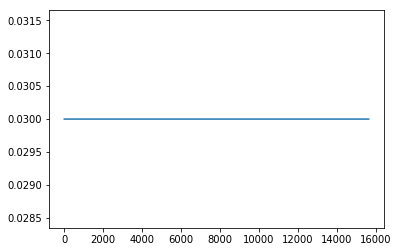

In [23]:
model = RestNet.ResNet18().to(device)
learner = Learner(data_loader_train, data_loader_test, model, criterion)
learner.fit(0.03, 20, 0)

### Train with cos annealing lr

---- epoch:0 ------
   [train] Average loss: 2.8279, acc: 32.56%
   [test] Average loss: 2.2512, acc: 47.37%
---- epoch:1 ------
   [train] Average loss: 1.8687, acc: 56.58%
   [test] Average loss: 1.6774, acc: 61.63%
---- epoch:2 ------
   [train] Average loss: 1.8218, acc: 58.21%
   [test] Average loss: 2.1404, acc: 54.02%
---- epoch:3 ------
   [train] Average loss: 1.3330, acc: 69.81%
   [test] Average loss: 1.2065, acc: 73.23%
---- epoch:4 ------
   [train] Average loss: 0.9558, acc: 78.44%
   [test] Average loss: 0.9790, acc: 78.72%
---- epoch:5 ------
   [train] Average loss: 0.6535, acc: 85.47%
   [test] Average loss: 0.9373, acc: 79.62%
---- epoch:6 ------
   [train] Average loss: 1.0499, acc: 76.57%
   [test] Average loss: 1.1462, acc: 75.61%
---- epoch:7 ------
   [train] Average loss: 0.8326, acc: 81.45%
   [test] Average loss: 1.1128, acc: 76.49%
---- epoch:8 ------
   [train] Average loss: 0.6488, acc: 85.42%
   [test] Average loss: 1.0235, acc: 79.45%
---- epoch:9 ------

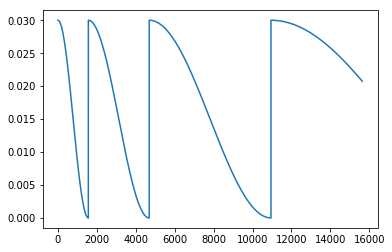

In [24]:
model = RestNet.ResNet18().to(device)
learner = Learner(data_loader_train, data_loader_test, model, criterion)
learner.fit(0.03, 20)